In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [10, 6]
import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

0it [00:00, ?it/s]

In [4]:
COLUMN_OF_INTEREST =['QUOTE_UNIXTIME','QUOTE_DATE','EXPIRE_DATE','EXPIRE_UNIX',
                            'DTE','C_BID','C_ASK', 'P_BID','P_ASK',
                             'UNDERLYING_LAST','STRIKE','STRIKE_DISTANCE']

In [5]:
df_options_spx = pd.read_csv('data/2020-2022_SPX_30days.csv')

# convert QUOTE_DATE and EXPIRE_DATE to datetime
df_options_spx['QUOTE_DATE'] = pd.to_datetime(df_options_spx['QUOTE_DATE'])
df_options_spx['EXPIRE_DATE'] = pd.to_datetime(df_options_spx['EXPIRE_DATE'])

# drop QUOTE_UNIXTIME and EXPIRE_UNIX
df_options_spx = df_options_spx.drop(['QUOTE_UNIXTIME', 'EXPIRE_UNIX'], axis=1)

# set "" to NaN
df_options_spx = df_options_spx.replace(r'^\s*$', np.nan, regex=True)

# drop rows with NaN
df_options_spx = df_options_spx.dropna()

# convert C_BID, C_ASK, P_BID, P_ASK to float
df_options_spx['C_BID'] = df_options_spx['C_BID'].astype(float)
df_options_spx['C_ASK'] = df_options_spx['C_ASK'].astype(float)
df_options_spx['P_BID'] = df_options_spx['P_BID'].astype(float)
df_options_spx['P_ASK'] = df_options_spx['P_ASK'].astype(float)

In [6]:
df_options_spx.dtypes

QUOTE_DATE         datetime64[ns]
EXPIRE_DATE        datetime64[ns]
DTE                       float64
C_BID                     float64
C_ASK                     float64
P_BID                     float64
P_ASK                     float64
UNDERLYING_LAST           float64
STRIKE                    float64
STRIKE_DISTANCE           float64
dtype: object

In [7]:
df_options_spx.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE
0,2020-01-03,2020-01-03,0.0,1826.61,1849.20,0.0,0.05,3234.35,1400.0,1834.3
1,2020-01-03,2020-01-03,0.0,1726.60,1749.30,0.0,0.05,3234.35,1500.0,1734.3
2,2020-01-03,2020-01-03,0.0,1626.60,1649.19,0.0,0.04,3234.35,1600.0,1634.3
3,2020-01-03,2020-01-03,0.0,1526.60,1549.31,0.0,0.05,3234.35,1700.0,1534.3
4,2020-01-03,2020-01-03,0.0,1426.60,1449.30,0.0,0.04,3234.35,1800.0,1434.3


In [8]:
# Calculate the rolling volatility of the underlying price
import yfinance as yf
from pypfopt.risk_models import CovarianceShrinkage

TICKER = ['SPY']

start_date = '2017-01-01' # you need to have at least 2 years of data before the start date as we are calculating the rolling volatility of 2 years
end_date = '2023-01-01' # end date is exclusive, the data will be downloaded until 2022-12-31

df = yf.download(TICKER, start=start_date, end=end_date)

# calculate the rolling volatility of 2 years (252 trading days per year)
# rolling_period = 252*2
rolling_period = int(252)
# dt = 1/252

# VOLATILITY METHOD 1: calculate the volatility using log return and take the standard deviation as is
# df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# df['volatility'] = df['log_return'].rolling(rolling_period).std() * np.sqrt(252)

# VOLATILITY METHOD 2: calculate the volatility using log return and CovarianceShrinkage
df_spy = df['Adj Close']
df_spy.index.name = None
df['volatility'] = np.nan

#Apply rolling period of years to CovarianceShrinkage
for i in range(rolling_period, len(df_spy)):
    cov_matrix = CovarianceShrinkage(df_spy.iloc[i-rolling_period:i], log_returns=True).ledoit_wolf() 

    #calculate the volatility. cov_matrix is annualized, so no need to multiply by sqrt(252)
    df['volatility'].iloc[i] = np.sqrt(cov_matrix.iloc[0,0])
    
# we only need the data from 2020 to 2022
df = df.loc['2020-01-01':'2022-12-31']

[*********************100%***********************]  1 of 1 completed


In [9]:
# risk free rate for 2020 to 2022 is around 2.5% per annum
risk_free_rate = 0.025

# dividend yield is rate is roughly 1.5% per annum for SPY
dividend_yield = 0.015

In [10]:
# import the Binomial model
from trinomial_model import trinomial_model

In [11]:
# merge the dataframes of df_options and df where df_options QUOTE_DATE is same as df index
df_model_input = df_options_spx.merge(df['volatility'], left_on='QUOTE_DATE', right_on=df.index)
df_model_input = df_model_input[df_model_input['DTE']==30]

In [12]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility
382,2020-01-06,2020-02-05,30.0,1241.90,1248.39,0.00,0.14,3246.23,2000.0,1246.2,0.119088
383,2020-01-06,2020-02-05,30.0,1142.89,1148.59,0.10,0.16,3246.23,2100.0,1146.2,0.119088
384,2020-01-06,2020-02-05,30.0,1092.10,1098.70,0.10,0.20,3246.23,2150.0,1096.2,0.119088
385,2020-01-06,2020-02-05,30.0,1043.10,1048.80,0.05,0.20,3246.23,2200.0,1046.2,0.119088
386,2020-01-06,2020-02-05,30.0,993.20,998.91,0.10,0.21,3246.23,2250.0,996.2,0.119088


In [13]:
# backtest the binomial model
# track the progress of the backtest
N_PLUS=0
df_model_input['binomial_model_crr_call'] = df_model_input.progress_apply(
    lambda x: trinomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=True), axis=1)

  0%|          | 0/38928 [00:00<?, ?it/s]

In [14]:
# backtest the binomial model
# track the progress of the backtest

N_PLUS=0
df_model_input['binomial_model_crr_put'] = df_model_input.progress_apply(
    lambda x: trinomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=True), axis=1)

  0%|          | 0/38928 [00:00<?, ?it/s]

In [15]:
df_model_input['binomial_model_jr_call'] = df_model_input['binomial_model_crr_call']
df_model_input['binomial_model_jr_put'] = df_model_input['binomial_model_crr_put']

In [16]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility,binomial_model_crr_call,binomial_model_crr_put,binomial_model_jr_call,binomial_model_jr_put
382,2020-01-06,2020-02-05,30.0,1241.90,1248.39,0.00,0.14,3246.23,2000.0,1246.2,0.119088,1250.335253,0.0,1250.335253,0.0
383,2020-01-06,2020-02-05,30.0,1142.89,1148.59,0.10,0.16,3246.23,2100.0,1146.2,0.119088,1150.540521,0.0,1150.540521,0.0
384,2020-01-06,2020-02-05,30.0,1092.10,1098.70,0.10,0.20,3246.23,2150.0,1096.2,0.119088,1100.643155,0.0,1100.643155,0.0
385,2020-01-06,2020-02-05,30.0,1043.10,1048.80,0.05,0.20,3246.23,2200.0,1046.2,0.119088,1050.745790,0.0,1050.745790,0.0
386,2020-01-06,2020-02-05,30.0,993.20,998.91,0.10,0.21,3246.23,2250.0,996.2,0.119088,1000.848424,0.0,1000.848424,0.0


In [17]:
# save the dataframe to csv
# df_model_input.to_csv('./data/df_model_output_spx.csv')

# load the dataframe from csv
# df_model_input = pd.read_csv('./data/df_model_output_spx.csv', index_col=0)
# df_model_input['QUOTE_DATE'] = pd.to_datetime(df_model_input['QUOTE_DATE'])
# df_model_input['EXPIRE_DATE'] = pd.to_datetime(df_model_input['EXPIRE_DATE'])

In [18]:
df_eval = df_model_input[['QUOTE_DATE', 
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_eval['C_PRICE'] = (df_eval['C_BID'] + df_eval['C_ASK'])/2
df_eval['P_PRICE'] = (df_eval['P_BID'] + df_eval['P_ASK'])/2
df_eval.head()

,QUOTE_DATE,binomial_model_crr_call,binomial_model_jr_call,C_BID,C_ASK,binomial_model_crr_put,binomial_model_jr_put,P_BID,P_ASK,DTE,STRIKE,C_PRICE,P_PRICE
382,2020-01-06,1250.335253,1250.335253,1241.90,1248.39,0.0,0.0,0.00,0.14,30.0,2000.0,1245.145,0.070
383,2020-01-06,1150.540521,1150.540521,1142.89,1148.59,0.0,0.0,0.10,0.16,30.0,2100.0,1145.740,0.130
384,2020-01-06,1100.643155,1100.643155,1092.10,1098.70,0.0,0.0,0.10,0.20,30.0,2150.0,1095.400,0.150
385,2020-01-06,1050.745790,1050.745790,1043.10,1048.80,0.0,0.0,0.05,0.20,30.0,2200.0,1045.950,0.125
386,2020-01-06,1000.848424,1000.848424,993.20,998.91,0.0,0.0,0.10,0.21,30.0,2250.0,996.055,0.155


In [19]:
#calculate absolute error of binomial model
df_eval['binomial_model_crr_call_error'] = df_eval['binomial_model_crr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_jr_call_error'] = df_eval['binomial_model_jr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_crr_put_error'] = df_eval['binomial_model_crr_put'] - df_eval['P_PRICE']
df_eval['binomial_model_jr_put_error'] = df_eval['binomial_model_jr_put'] - df_eval['P_PRICE']

#calculate root mean squared error of binomial model
print('Root Mean Squared Error of CRR Call model:',np.sqrt(np.mean(df_eval['binomial_model_crr_call_error']**2)))
print('Root Mean Squared Error of JR Call model:',np.sqrt(np.mean(df_eval['binomial_model_jr_call_error']**2)))
print('Root Mean Squared Error of CRR Put model:',np.sqrt(np.mean(df_eval['binomial_model_crr_put_error']**2)))
print('Root Mean Squared Error of JR Put model:',np.sqrt(np.mean(df_eval['binomial_model_jr_put_error']**2)))

#calculate mean absolute error of binomial model
print('Mean Absolute Error of CRR Call model:',np.mean(np.abs(df_eval['binomial_model_crr_call_error'])))
print('Mean Absolute Error of JR Call model:',np.mean(np.abs(df_eval['binomial_model_jr_call_error'])))
print('Mean Absolute Error of CRR Put model:',np.mean(np.abs(df_eval['binomial_model_crr_put_error'])))
print('Mean Absolute Error of JR Put model:',np.mean(np.abs(df_eval['binomial_model_jr_put_error'])))

#calculate mean absolute percentage error of binomial model
print('Percentage Mean Absolute Error of CRR Call model:', np.mean(np.abs(df_eval['binomial_model_crr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Call model:', np.mean(np.abs(df_eval['binomial_model_jr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of CRR Put model:', np.mean(np.abs(df_eval['binomial_model_crr_put_error']/df_eval['P_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Put model:', np.mean(np.abs(df_eval['binomial_model_jr_put_error']/df_eval['P_PRICE']))*100,'%')


Root Mean Squared Error of CRR Call model: 21.030970791568013
Root Mean Squared Error of JR Call model: 21.030970791568013
Root Mean Squared Error of CRR Put model: 21.684328101367125
Root Mean Squared Error of JR Put model: 21.684328101367125
Mean Absolute Error of CRR Call model: 12.726256282729704
Mean Absolute Error of JR Call model: 12.726256282729704
Mean Absolute Error of CRR Put model: 13.76588223314767
Mean Absolute Error of JR Put model: 13.76588223314767
Percentage Mean Absolute Error of CRR Call model: 95.26766200430427 %
Percentage Mean Absolute Error of JR Call model: 95.26766200430427 %
Percentage Mean Absolute Error of CRR Put model: 51.97881137310281 %
Percentage Mean Absolute Error of JR Put model: 51.97881137310281 %


In [20]:
df_input = df_model_input[['QUOTE_DATE', 'EXPIRE_DATE',
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_input['C_PRICE'] = (df_input['C_BID'] + df_input['C_ASK'])/2
df_input['P_PRICE'] = (df_input['P_BID'] + df_input['P_ASK'])/2
df_input.drop(['C_BID','C_ASK', 'P_BID','P_ASK',], axis=1, inplace=True)
df_input.head()

,QUOTE_DATE,EXPIRE_DATE,binomial_model_crr_call,binomial_model_jr_call,binomial_model_crr_put,binomial_model_jr_put,DTE,STRIKE,C_PRICE,P_PRICE
382,2020-01-06,2020-02-05,1250.335253,1250.335253,0.0,0.0,30.0,2000.0,1245.145,0.070
383,2020-01-06,2020-02-05,1150.540521,1150.540521,0.0,0.0,30.0,2100.0,1145.740,0.130
384,2020-01-06,2020-02-05,1100.643155,1100.643155,0.0,0.0,30.0,2150.0,1095.400,0.150
385,2020-01-06,2020-02-05,1050.745790,1050.745790,0.0,0.0,30.0,2200.0,1045.950,0.125
386,2020-01-06,2020-02-05,1000.848424,1000.848424,0.0,0.0,30.0,2250.0,996.055,0.155


In [21]:
df_price = df_model_input[['QUOTE_DATE', 'UNDERLYING_LAST']]
df_price = df_price.drop_duplicates()
df_price = df_price.set_index('QUOTE_DATE')

# remove rows where expiry date is greater max quote date
df_input = df_input[df_input['EXPIRE_DATE'] <= df_price.index.max()]
df_input['UNDERLYING_PRICE_EXPIRE'] = df_input['EXPIRE_DATE'].progress_apply(
    lambda x: df_price.loc[x]['UNDERLYING_LAST'] if x in df_price.index
    else df_price.loc[df_price.index[df_price.index.get_loc(x, method='bfill')]]['UNDERLYING_LAST'])

  0%|          | 0/37131 [00:00<?, ?it/s]

In [22]:
df_binomial_model_crr = df_input[['binomial_model_crr_call', 'binomial_model_crr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_crr = df_binomial_model_crr.rename(columns={'binomial_model_crr_call':'CALL', 'binomial_model_crr_put':'PUT'})

df_binomial_model_jr = df_input[['binomial_model_jr_call', 'binomial_model_jr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_jr = df_binomial_model_jr.rename(columns={'binomial_model_jr_call':'CALL', 'binomial_model_jr_put':'PUT'})

In [23]:
# import calculate_profit function from backtesting.py
from backtesting import calculate_profit, max_drawdown, sharpe_ratio, calmars_ratio, drawdown

In [24]:
df_binomial_model_crr = calculate_profit(df_binomial_model_crr, long_call=True, short_call=True, long_put=True, short_put=True)

df_binomial_model_jr = calculate_profit(df_binomial_model_jr, long_call=True, short_call=True, long_put=True, short_put=True)

Mean Profit/Loss of CRR model: 2.129943039508774
Mean Profit/Loss of JR model: 2.129943039508774
Volatility of CRR model: 213.2996650588021
Volatility of JR model: 213.2996650588021
Total Profit/Loss of CRR model: 79086.91500000028
Total Profit/Loss of JR model: 79086.91500000028
Plotting daily Profit/Loss of CRR and JR model


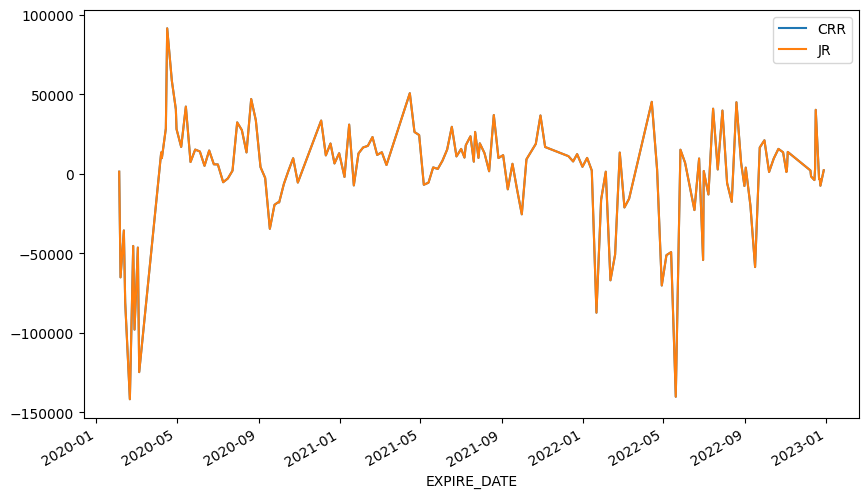

Plotting total Profit/Loss of CRR and JR model


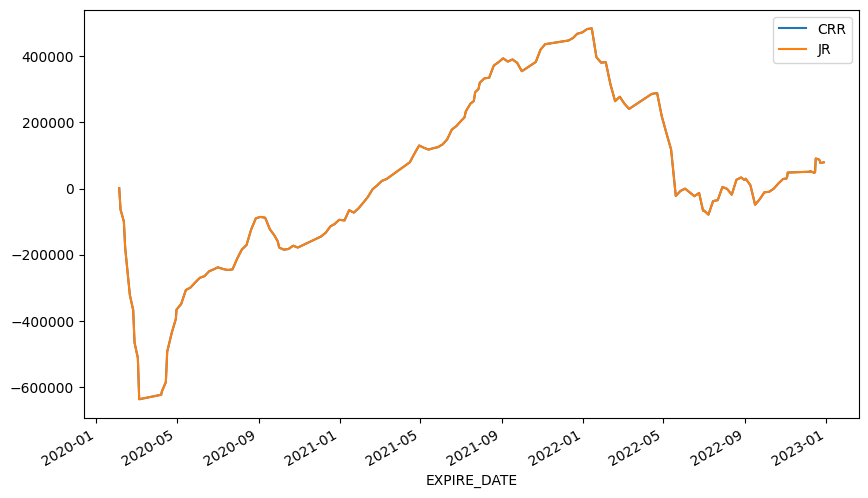

In [25]:
print('Mean Profit/Loss of CRR model:',np.mean(df_binomial_model_crr['PROFIT_LOSS']))
print('Mean Profit/Loss of JR model:',np.mean(df_binomial_model_jr['PROFIT_LOSS']))
print('Volatility of CRR model:',np.std(df_binomial_model_crr['PROFIT_LOSS']))
print('Volatility of JR model:',np.std(df_binomial_model_jr['PROFIT_LOSS']))
print('Total Profit/Loss of CRR model:',np.sum(df_binomial_model_crr['PROFIT_LOSS']))
print('Total Profit/Loss of JR model:',np.sum(df_binomial_model_jr['PROFIT_LOSS']))

df_total_profit_loss_crr = df_binomial_model_crr['PROFIT_LOSS'].sum()
df_total_profit_loss_jr = df_binomial_model_jr['PROFIT_LOSS'].sum()

print('Plotting daily Profit/Loss of CRR and JR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.legend(['CRR', 'JR'])
plt.show()

print('Plotting total Profit/Loss of CRR and JR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.legend(['CRR', 'JR'])
plt.show()

Plotting Profit/Loss of Long and Short of Call and Put of CRR model


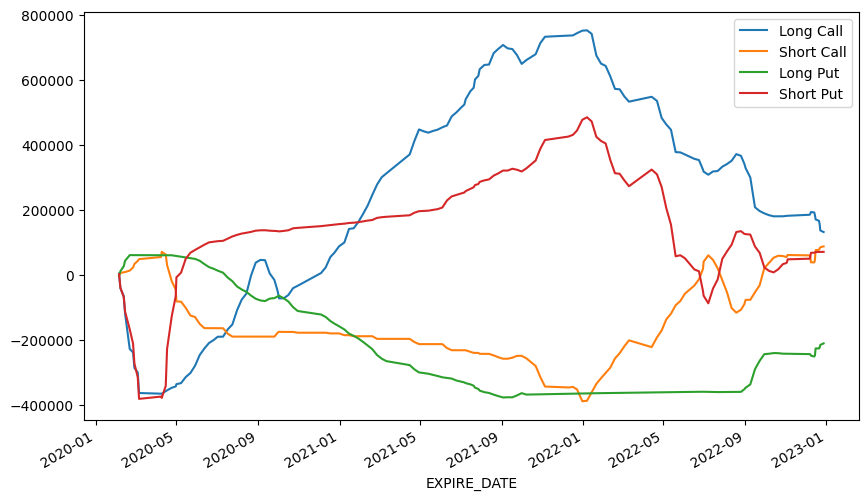

Plotting Profit/Loss of Long and Short of Call and Put of JR model


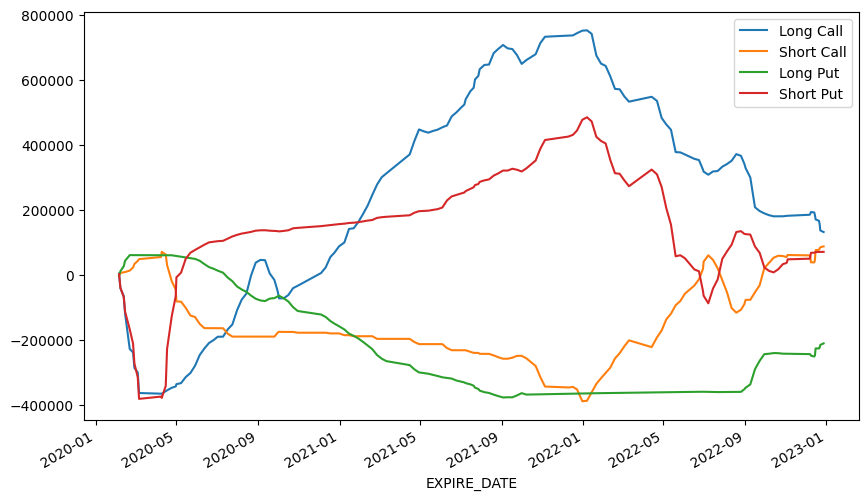

Plotting Profit/Loss of Call and Put of CRR model


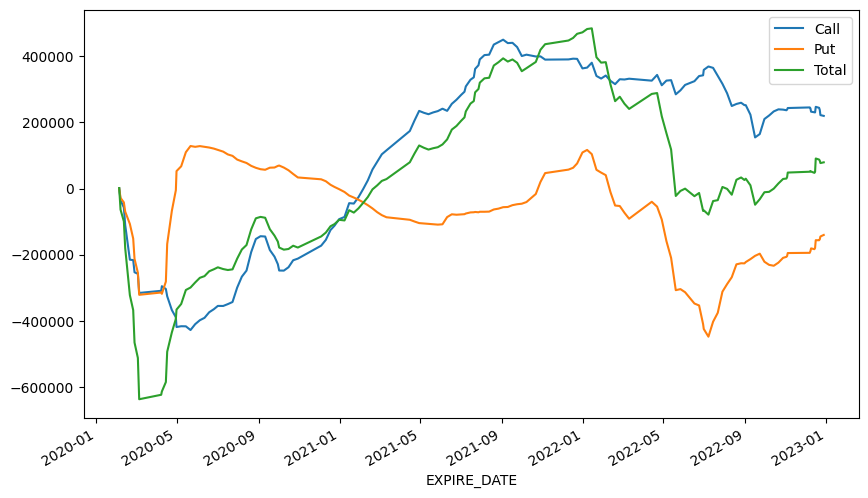

Plotting Profit/Loss of Call and Put of JR model


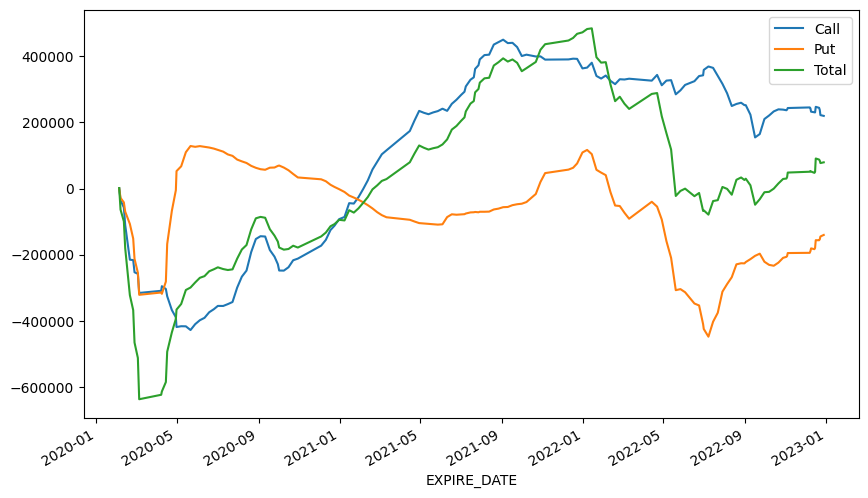

In [26]:
# plot profit/loss of long and short of call and put for crr model
print('Plotting Profit/Loss of Long and Short of Call and Put of CRR model')
df_long_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == 1]
df_short_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == -1]
df_long_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == 1]
df_short_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == -1]
(df_long_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Long Call')
(df_short_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Short Call')
(df_long_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Long Put')
(df_short_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Short Put')
plt.legend()
plt.show()

# plot profit/loss of long and short of call and put for jr model
print('Plotting Profit/Loss of Long and Short of Call and Put of JR model')
df_long_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == 1]
df_short_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == -1]
df_long_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == 1]
df_short_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == -1]
(df_long_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Long Call')
(df_short_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Short Call')
(df_long_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Long Put')
(df_short_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Short Put')
plt.legend()
plt.show()

# plot profit/loss of call and put for crr model
print('Plotting Profit/Loss of Call and Put of CRR model')
(df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()).plot()
plt.legend(['Call','Put','Total'])
plt.show()

# plot profit/loss of call and put for jr model
print('Plotting Profit/Loss of Call and Put of JR model')
(df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()).plot() 
plt.legend(['Call','Put','Total'])
plt.show()

In [27]:
initial_capital = 500000
daily_portfotio_value_crr = df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum() + initial_capital
daily_portfotio_value_jr = df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum() + initial_capital
pct_cumulative_return_crr = (daily_portfotio_value_crr/daily_portfotio_value_crr.iloc[0]-1)
pct_cumulative_return_jr = (daily_portfotio_value_jr/daily_portfotio_value_jr.iloc[0]-1)
pct_change_crr = daily_portfotio_value_crr.pct_change().dropna()
pct_change_jr = daily_portfotio_value_jr.pct_change().dropna()


Percentage Daily Profit/Loss of CRR and JR model


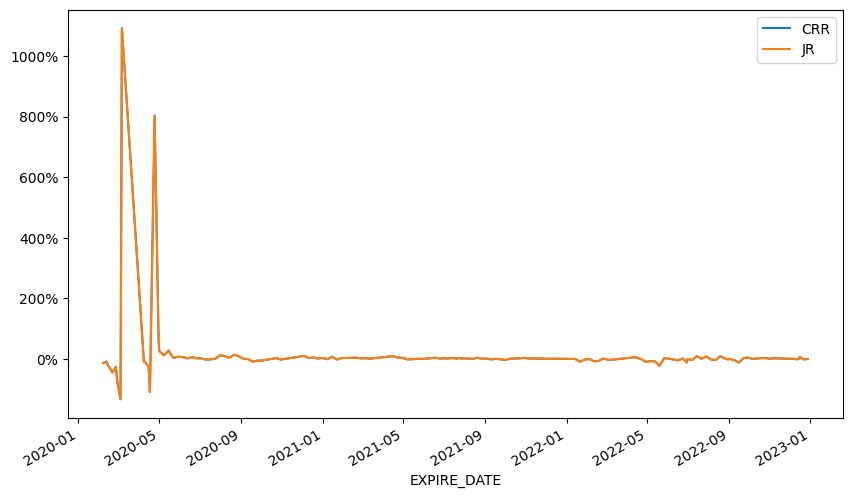

Percentage Cumulative Return of CRR and JR model


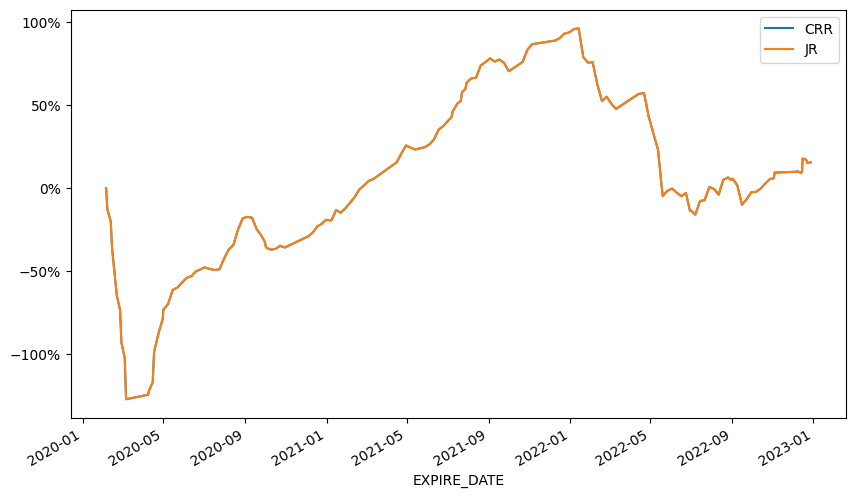

Plotting Percentage of Profit/Loss of Long and Short of Call and Put of CRR model


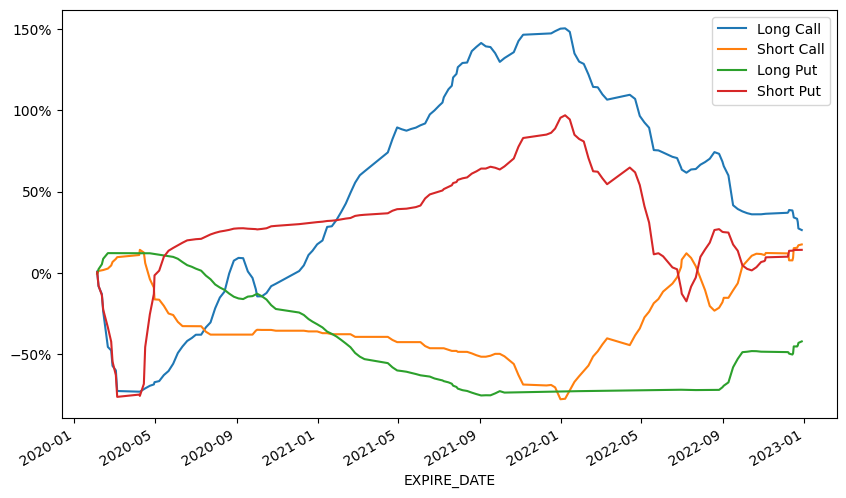

Plotting Percentage of Profit/Loss of Call and Put of CRR model


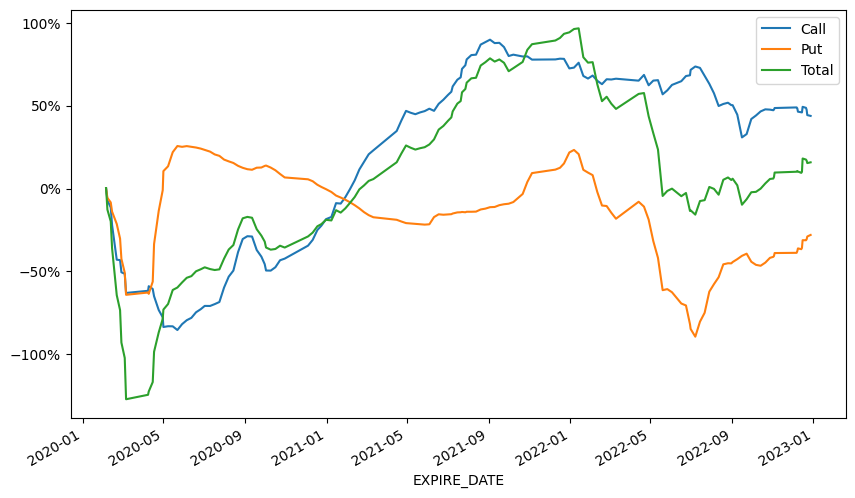

In [28]:
# plot percentage daily profit/loss of crr and jr model
print('Percentage Daily Profit/Loss of CRR and JR model')
pct_change_crr.plot()
pct_change_jr.plot()
plt.legend(['CRR','JR'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# plot percentage cumulative return of crr and jr model
print('Percentage Cumulative Return of CRR and JR model')
pct_cumulative_return_crr.plot()
pct_cumulative_return_jr.plot()
plt.legend(['CRR','JR'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# plot percentage of profit/loss of long and short of call and put for crr model
print('Plotting Percentage of Profit/Loss of Long and Short of Call and Put of CRR model')
(df_long_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/initial_capital).plot(label='Long Call')
(df_short_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/initial_capital).plot(label='Short Call')
(df_long_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/initial_capital).plot(label='Long Put')
(df_short_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/initial_capital).plot(label='Short Put')
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# plot percentage of profit/loss of call and put for crr model
print('Plotting Percentage of Profit/Loss of Call and Put of CRR model')
(df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()/initial_capital).plot()
plt.legend(['Call','Put','Total'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Model performance

Sharpe Ratio of CRR and JR model
Sharpe Ratio of CRR model: 1.60891223320059
Sharpe Ratio of JR model: 1.60891223320059
Calmars Ratio of CRR and JR model
Calmars Ratio of CRR model: 22.082249171496002
Calmars Ratio of JR model: 22.082249171496002
Max Drawdown of CRR and JR model
Max Drawdown of CRR model (in percentage): -131.19153510636642 %
Max Drawdown of JR model (in percentage): -131.19153510636642 %


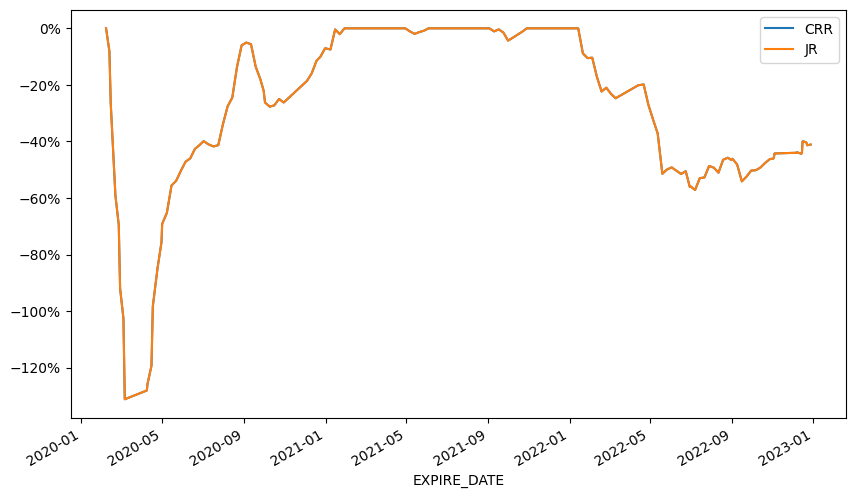

In [29]:
# calculate sharpe ratio
print('Sharpe Ratio of CRR and JR model')
sharpe_ratio_crr = sharpe_ratio(pct_change_crr, risk_free_rate)
sharpe_ratio_jr = sharpe_ratio(pct_change_jr, risk_free_rate)
print('Sharpe Ratio of CRR model:', sharpe_ratio_crr)
print('Sharpe Ratio of JR model:', sharpe_ratio_jr)
# calculate calmars ratio
print('Calmars Ratio of CRR and JR model')
calmars_ratio_crr = calmars_ratio(pct_change_crr, risk_free_rate)
calmars_ratio_jr = calmars_ratio(pct_change_jr, risk_free_rate)
print('Calmars Ratio of CRR model:', calmars_ratio_crr)
print('Calmars Ratio of JR model:', calmars_ratio_jr)
# Max Drawdown
print('Max Drawdown of CRR and JR model')
print('Max Drawdown of CRR model (in percentage):',max_drawdown(pct_change_crr)*100, '%')
print('Max Drawdown of JR model (in percentage):',max_drawdown(pct_change_crr)*100, '%')
drawdown(pct_change_crr).plot()
drawdown(pct_change_jr).plot()
plt.legend(['CRR','JR'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()


In [30]:
-(pct_cumulative_return_crr.cummax() - pct_cumulative_return_crr).max()

-1.2714337124796147

# Limiting devitation to 10%

In [31]:
df_binomial_model_crr = calculate_profit(df_binomial_model_crr, long_call=True, short_call=True, long_put=True, short_put=True, deviation=0.1)

df_binomial_model_jr = calculate_profit(df_binomial_model_jr, long_call=True, short_call=True, long_put=True, short_put=True, deviation=0.1)

Mean Profit/Loss of CRR model: 7.942048961783956
Mean Profit/Loss of JR model: 7.942048961783956
Volatility of CRR model: 200.00529050265212
Volatility of JR model: 200.00529050265212
Total Profit/Loss of CRR model: 294896.2200000001
Total Profit/Loss of JR model: 294896.2200000001
Plotting daily Profit/Loss of CRR and JR model


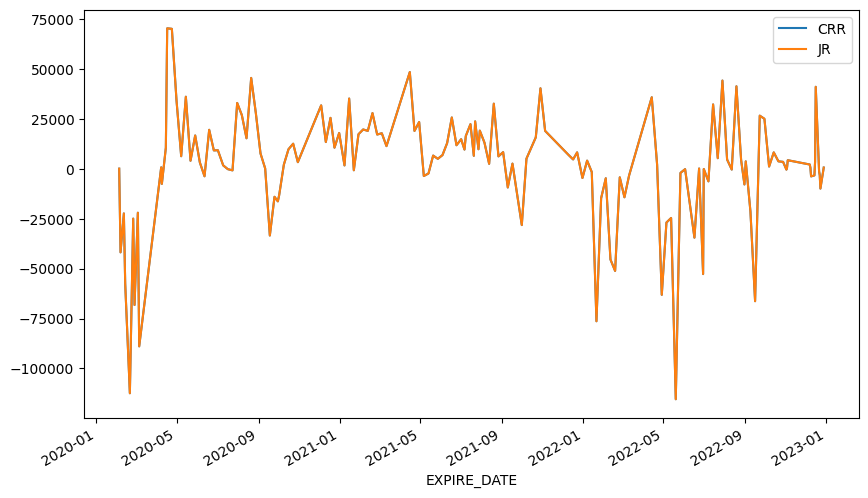

Plotting total Profit/Loss of CRR and JR model


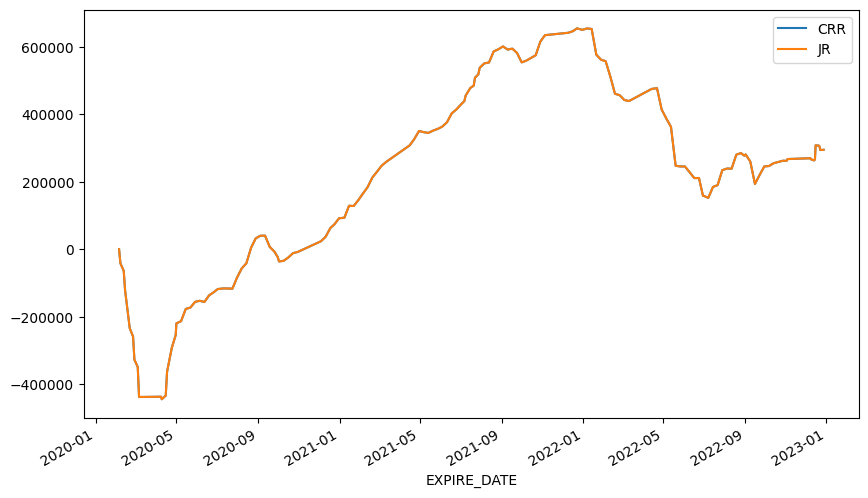

In [32]:
print('Mean Profit/Loss of CRR model:',np.mean(df_binomial_model_crr['PROFIT_LOSS']))
print('Mean Profit/Loss of JR model:',np.mean(df_binomial_model_jr['PROFIT_LOSS']))
print('Volatility of CRR model:',np.std(df_binomial_model_crr['PROFIT_LOSS']))
print('Volatility of JR model:',np.std(df_binomial_model_jr['PROFIT_LOSS']))
print('Total Profit/Loss of CRR model:',np.sum(df_binomial_model_crr['PROFIT_LOSS']))
print('Total Profit/Loss of JR model:',np.sum(df_binomial_model_jr['PROFIT_LOSS']))

df_total_profit_loss_crr = df_binomial_model_crr['PROFIT_LOSS'].sum()
df_total_profit_loss_jr = df_binomial_model_jr['PROFIT_LOSS'].sum()

print('Plotting daily Profit/Loss of CRR and JR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.legend(['CRR', 'JR'])
plt.show()

print('Plotting total Profit/Loss of CRR and JR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.legend(['CRR', 'JR'])
plt.show()

Plotting Profit/Loss of Long and Short of Call and Put of CRR model


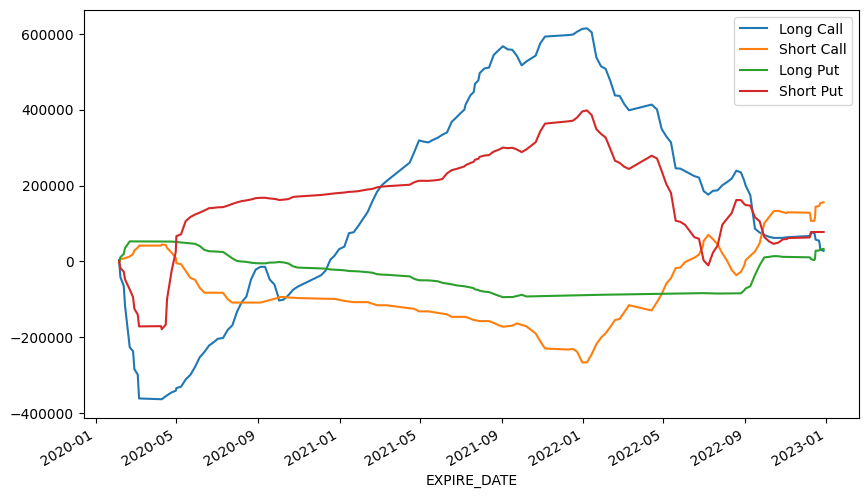

Plotting Profit/Loss of Long and Short of Call and Put of JR model


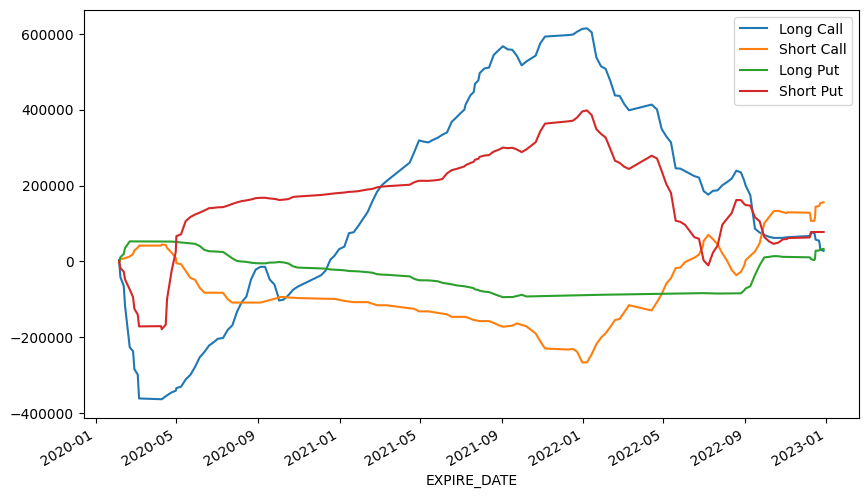

Plotting Profit/Loss of Call and Put of CRR model


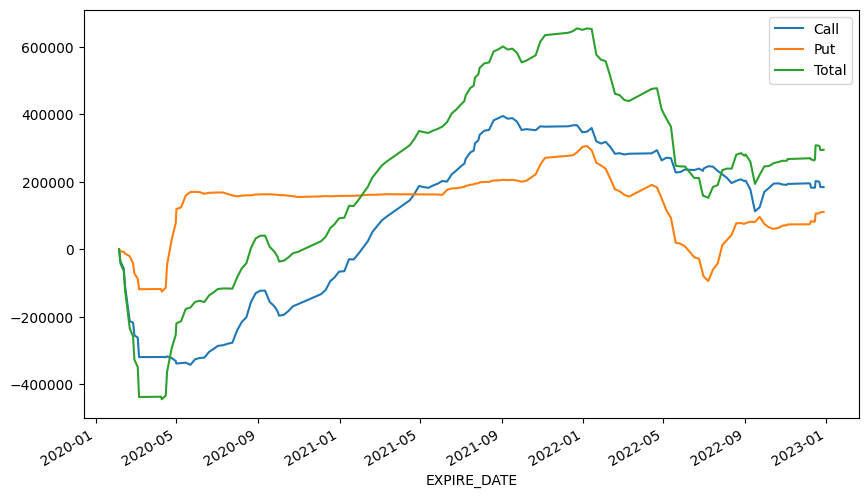

Plotting Profit/Loss of Call and Put of JR model


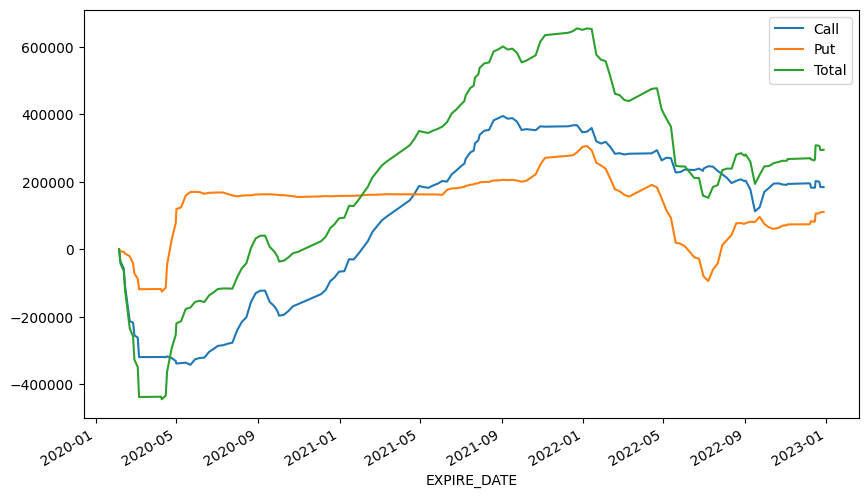

In [33]:
# plot profit/loss of long and short of call and put for crr model
print('Plotting Profit/Loss of Long and Short of Call and Put of CRR model')
df_long_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == 1]
df_short_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == -1]
df_long_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == 1]
df_short_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == -1]
(df_long_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Long Call')
(df_short_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Short Call')
(df_long_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Long Put')
(df_short_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Short Put')
plt.legend()
plt.show()

# plot profit/loss of long and short of call and put for jr model
print('Plotting Profit/Loss of Long and Short of Call and Put of JR model')
df_long_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == 1]
df_short_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == -1]
df_long_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == 1]
df_short_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == -1]
(df_long_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Long Call')
(df_short_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()).plot(label='Short Call')
(df_long_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Long Put')
(df_short_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()).plot(label='Short Put')
plt.legend()
plt.show()

# plot profit/loss of call and put for crr model
print('Plotting Profit/Loss of Call and Put of CRR model')
(df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()).plot()
plt.legend(['Call','Put','Total'])
plt.show()

# plot profit/loss of call and put for jr model
print('Plotting Profit/Loss of Call and Put of JR model')
(df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()).plot() 
plt.legend(['Call','Put','Total'])
plt.show()

In [34]:
daily_portfotio_value_crr = df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum() + initial_capital
daily_portfotio_value_jr = df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum() + initial_capital
pct_cumulative_return_crr = (daily_portfotio_value_crr/daily_portfotio_value_crr.iloc[0]-1)
pct_cumulative_return_jr = (daily_portfotio_value_jr/daily_portfotio_value_jr.iloc[0]-1)
pct_change_crr = daily_portfotio_value_crr.pct_change().dropna()
pct_change_jr = daily_portfotio_value_jr.pct_change().dropna()


Percentage Daily Profit/Loss of CRR and JR model


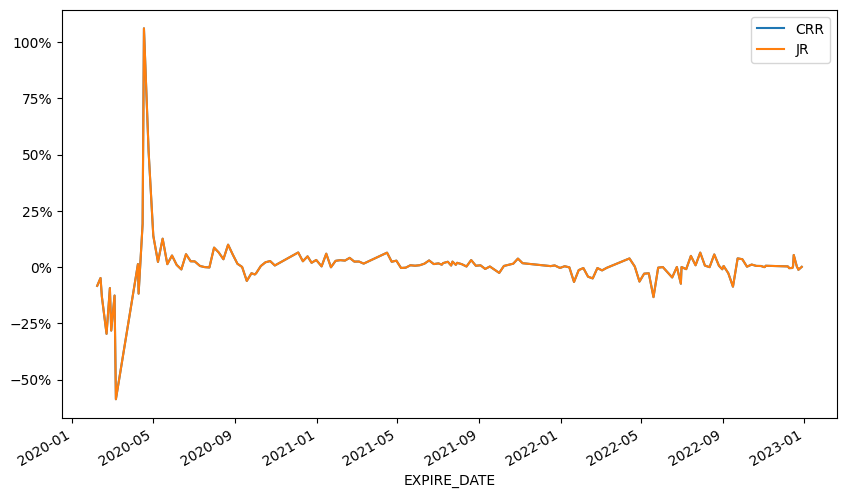

Percentage Cumulative Return of CRR and JR model


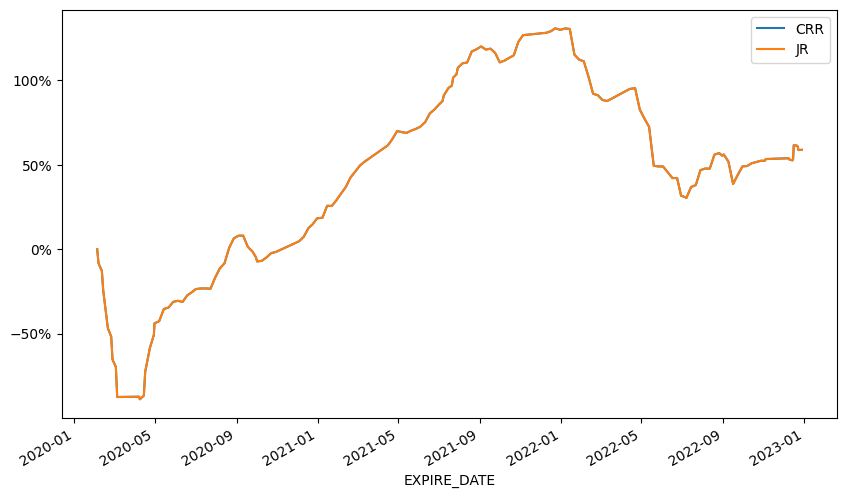

Plotting Percentage of Profit/Loss of Long and Short of Call and Put of CRR model


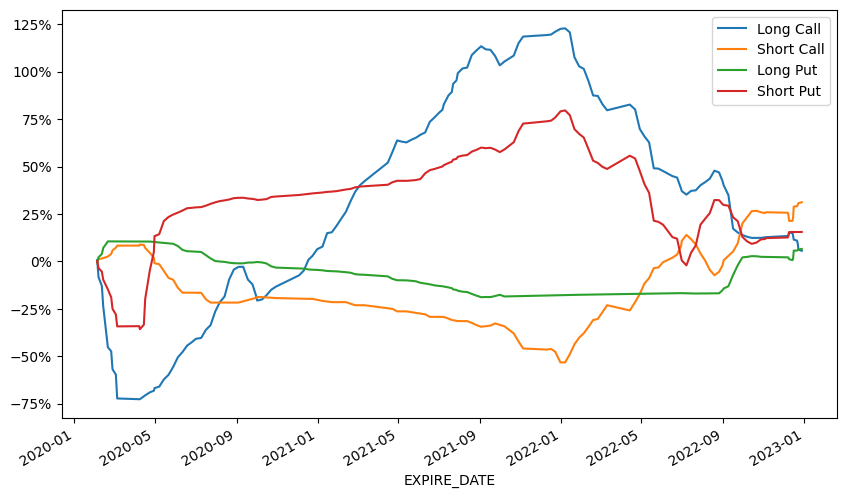

Plotting Percentage of Profit/Loss of Call and Put of CRR model


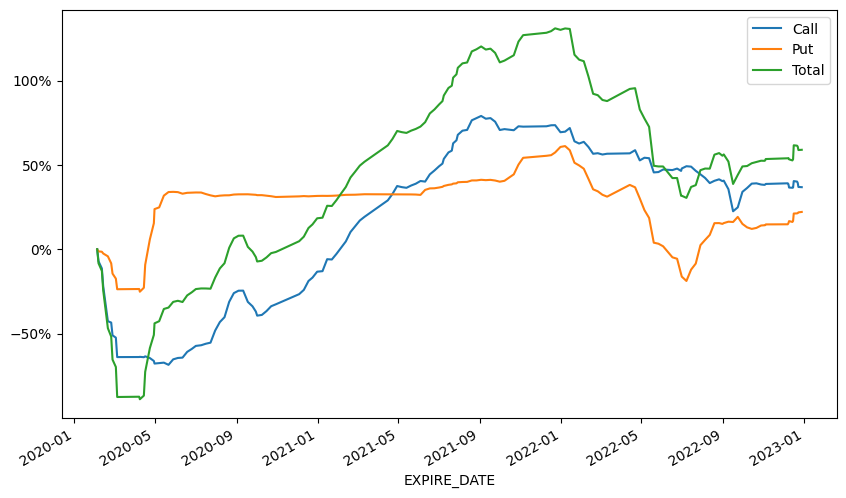

In [35]:
# plot percentage daily profit/loss of crr and jr model
print('Percentage Daily Profit/Loss of CRR and JR model')
pct_change_crr.plot()
pct_change_jr.plot()
plt.legend(['CRR','JR'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# plot percentage cumulative return of crr and jr model
print('Percentage Cumulative Return of CRR and JR model')
pct_cumulative_return_crr.plot()
pct_cumulative_return_jr.plot()
plt.legend(['CRR','JR'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# plot percentage of profit/loss of long and short of call and put for crr model
print('Plotting Percentage of Profit/Loss of Long and Short of Call and Put of CRR model')
(df_long_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/initial_capital).plot(label='Long Call')
(df_short_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/initial_capital).plot(label='Short Call')
(df_long_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/initial_capital).plot(label='Long Put')
(df_short_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/initial_capital).plot(label='Short Put')
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# plot percentage of profit/loss of call and put for crr model
print('Plotting Percentage of Profit/Loss of Call and Put of CRR model')
(df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()/initial_capital).plot()
plt.legend(['Call','Put','Total'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Model performance

Sharpe Ratio of CRR and JR model
Sharpe Ratio of CRR model: 1.2731275006853555
Sharpe Ratio of JR model: 1.2731275006853555
Calmars Ratio of CRR and JR model
Calmars Ratio of CRR model: 2.8349969505728634
Calmars Ratio of JR model: 2.8349969505728634
Max Drawdown of CRR and JR model
Max Drawdown of CRR model (in percentage): -87.84074680922168 %
Max Drawdown of JR model (in percentage): -87.84074680922168 %


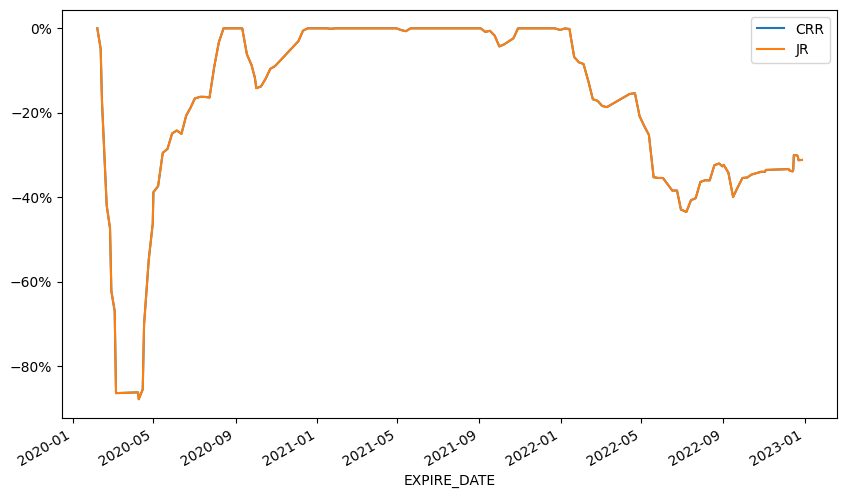

In [36]:
# calculate sharpe ratio
print('Sharpe Ratio of CRR and JR model')
sharpe_ratio_crr = sharpe_ratio(pct_change_crr, risk_free_rate)
sharpe_ratio_jr = sharpe_ratio(pct_change_jr, risk_free_rate)
print('Sharpe Ratio of CRR model:', sharpe_ratio_crr)
print('Sharpe Ratio of JR model:', sharpe_ratio_jr)
# calculate calmars ratio
print('Calmars Ratio of CRR and JR model')
calmars_ratio_crr = calmars_ratio(pct_change_crr, risk_free_rate)
calmars_ratio_jr = calmars_ratio(pct_change_jr, risk_free_rate)
print('Calmars Ratio of CRR model:', calmars_ratio_crr)
print('Calmars Ratio of JR model:', calmars_ratio_jr)
# Max Drawdown
print('Max Drawdown of CRR and JR model')
print('Max Drawdown of CRR model (in percentage):',max_drawdown(pct_change_crr)*100, '%')
print('Max Drawdown of JR model (in percentage):',max_drawdown(pct_change_crr)*100, '%')
drawdown(pct_change_crr).plot()
drawdown(pct_change_jr).plot()
plt.legend(['CRR','JR'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()
